<a href="https://colab.research.google.com/github/Beyza-N/nlp_cv_project/blob/main/grok_bitproje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
from transformers import pipeline
import cv2
import numpy as np
import os
from PIL import Image
import re

# --- Library Imports ---
try:
    from PIL import Image
except ImportError:
    !pip install Pillow
try:
    import cv2
except ImportError:
    !pip install opencv-python

# --- Text Classification ---
classifier = pipeline("text-classification", model="dbmdz/bert-base-turkish-cased", return_all_scores=False)

# --- Data Loading ---
csv_file_path = '/content/sample_data/haber_veri_seti/dataset.csv'
df = pd.read_csv(csv_file_path, names=['Haber Adı', 'Haber'])

# --- Logo Directory ---
LOGO_DIR = '/content/sample_data/haber_veri_seti/logos/'



def detect_logo(keyboard_image_path, logo_dir):
    """Detect logos using ORB feature matching with a ratio test."""
    try:
        # Load the keyboard image in grayscale
        keyboard_img = cv2.imread(keyboard_image_path, cv2.IMREAD_GRAYSCALE)
        if keyboard_img is None:
            print("Error: Could not load keyboard image.")
            return 0

        # Initialize ORB detector
        orb = cv2.ORB_create()
        kp_key, des_key = orb.detectAndCompute(keyboard_img, None)
        if des_key is None:
            print("Error: Insufficient features found in keyboard image.")
            return 0

        # Adjusted parameters
        min_match_count = 5  # Reduced to allow more matches
        ratio = 0.8          # Increased to be less strict
        matched_logo_count = 0

        # Process each logo in the directory
        for logo_filename in os.listdir(logo_dir):
            if logo_filename.endswith(('.png', '.jpg', '.jpeg')):
                logo_path = os.path.join(logo_dir, logo_filename)
                try:
                    logo_img = cv2.imread(logo_path, cv2.IMREAD_GRAYSCALE)
                    if logo_img is None:
                        print(f"Warning: Could not load {logo_path}.")
                        continue

                    kp_logo, des_logo = orb.detectAndCompute(logo_img, None)
                    if des_logo is None:
                        print(f"Warning: Insufficient features in {logo_path}.")
                        continue

                    # Perform feature matching
                    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
                    matches = bf.knnMatch(des_key, des_logo, k=2)

                    # Apply ratio test
                    good_matches = []
                    for m_n in matches:
                        if len(m_n) == 2:
                            m, n = m_n
                            if m.distance < ratio * n.distance:
                                good_matches.append(m)

                    # Print match count for debugging
                    print(f"{logo_filename}: {len(good_matches)} good matches")

                    # Check if the logo matches
                    if len(good_matches) >= min_match_count:
                        print(f"Keyboard logo matches {logo_filename} with {len(good_matches)}/{min_match_count} good matches.")
                        matched_logo_count += 1

                except Exception as e:
                    print(f"Error processing {logo_path}: {e}")
                    continue

        # Final result
        if matched_logo_count > 0:
            print(f"Keyboard logo matched with {matched_logo_count} logos in the folder.")
            return matched_logo_count
        else:
            print("Keyboard logo did not match any logos in the folder sufficiently.")
            return 0

    except Exception as e:
        print(f"Error during logo detection: {e}")
        return 0

    except Exception as e:
        print(f"Error during logo detection: {e}")
        return 0
def classify_and_label(haber_baslik, haber_metni, target_company, keywords):
    """Classify news based on text analysis with robust keyword matching."""
    combined_text = f"{haber_baslik} {haber_metni}".upper()
    text_match = False
    if target_company.upper() in combined_text:
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword.upper()) + r'\b', combined_text):
                try:
                    result = classifier(haber_metni[:512])
                    if result[0]['label'] == "LABEL_1":
                        text_match = True
                        break
                except Exception as e:
                    print(f"Text classification error: {e}")
    return text_match

# --- Main Execution ---
sirket_adi = input("Lütfen şirket adını girin: ").strip().upper()
anahtar_kelime_input = input("Lütfen anahtar kelimeleri virgülle ayırarak girin: ")
anahtar_kelimeler = [kelime.strip().upper() for kelime in anahtar_kelime_input.split(',')]
keyboard_image_path = input("Lütfen klavyedeki (yüklenecek) logonun dosya yolunu girin: ")

# Logo analysis
num_logo_positive = detect_logo(keyboard_image_path, LOGO_DIR)

# Initialize counters
num_text_positive = 0
num_overall_positive = 0

# Analyze news
for index, row in df.iterrows():
    haber_baslik = str(row['Haber Adı'])
    haber_metni = str(row['Haber'])

    text_match = classify_and_label(haber_baslik, haber_metni, sirket_adi, anahtar_kelimeler)

    if text_match:
        num_text_positive += 1

# Calculate overall results
num_overall_positive = num_text_positive + num_logo_positive

# --- Print Results ---
print("\n--- Sonuçlar ---")
print(f"Toplam Haber Sayısı: {len(df)}")
print(f"Metin İçin İlgili Haber Sayısı ({sirket_adi} ve Anahtar Kelimeler): {num_text_positive}")
print(f"Logo İçin İlgili Haber Sayısı: {num_logo_positive}")
print(f"Toplam İlgili Haber Sayısı (Metin VEYA Logo): {num_overall_positive}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Lütfen şirket adını girin: HAVELSAN
Lütfen anahtar kelimeleri virgülle ayırarak girin: yapay zeka, kadın
Lütfen klavyedeki (yüklenecek) logonun dosya yolunu girin: /content/sample_data/images2).jpeg
download1).jpeg: 7 good matches
Keyboard logo matches download1).jpeg with 7/5 good matches.
logosunu-yeniledi.jpeg: 6 good matches
Keyboard logo matches logosunu-yeniledi.jpeg with 6/5 good matches.
hq720.jpg: 3 good matches
images1).jpeg: 10 good matches
Keyboard logo matches images1).jpeg with 10/5 good matches.
havelsan_logo.jpeg: 378 good matches
Keyboard logo matches havelsan_logo.jpeg with 378/5 good matches.
Keyboard logo matched with 4 logos in the folder.

--- Sonuçlar ---
Toplam Haber Sayısı: 97
Metin İçin İlgili Haber Sayısı (HAVELSAN ve Anahtar Kelimeler): 3
Logo İçin İlgili Haber Sayısı: 4
Toplam İlgili Haber Sayısı (Metin VEYA Logo): 7


In [15]:
import pandas as pd
from transformers import pipeline
import cv2
import numpy as np
import os
from PIL import Image
import re

# --- Library Imports ---
try:
    from PIL import Image
except ImportError:
    !pip install Pillow
try:
    import cv2
except ImportError:
    !pip install opencv-python

# --- Text Classification ---
classifier = pipeline("text-classification", model="dbmdz/bert-base-turkish-cased", return_all_scores=False)

# --- Data Loading ---
csv_file_path = '/content/sample_data/haber_veri_seti/dataset.csv'
df = pd.read_csv(csv_file_path, names=['Haber Adı', 'Haber'])

# --- Logo Directory ---
LOGO_DIR = '/content/sample_data/haber_veri_seti/logos/'


def detect_logo(keyboard_image_path, logo_dir):
    """Detect logos using template matching with preprocessing."""
    try:
        # Load the keyboard image
        keyboard_img = cv2.imread(keyboard_image_path)
        if keyboard_img is None:
            print("Error: Could not load keyboard image.")
            return 0

        # Convert to grayscale and preprocess
        keyboard_gray = cv2.cvtColor(keyboard_img, cv2.COLOR_BGR2GRAY)
        keyboard_gray = cv2.GaussianBlur(keyboard_gray, (5, 5), 0)  # Reduce noise
        keyboard_gray = cv2.Canny(keyboard_gray, 100, 200)  # Edge detection for better matching

        # Resize keyboard image to a standard size for consistency (e.g., 800x600)
        keyboard_gray = cv2.resize(keyboard_gray, (800, 600))

        # Threshold for similarity (0 to 1, higher is stricter)
        similarity_threshold = 0.8
        matched_logo_count = 0

        # Process each logo in the directory
        for logo_filename in os.listdir(logo_dir):
            if logo_filename.endswith(('.png', '.jpg', '.jpeg')):
                logo_path = os.path.join(logo_dir, logo_filename)
                try:
                    # Load the logo image
                    logo_img = cv2.imread(logo_path)
                    if logo_img is None:
                        print(f"Warning: Could not load {logo_path}.")
                        continue

                    # Convert to grayscale and preprocess
                    logo_gray = cv2.cvtColor(logo_img, cv2.COLOR_BGR2GRAY)
                    logo_gray = cv2.GaussianBlur(logo_gray, (5, 5), 0)  # Reduce noise
                    logo_gray = cv2.Canny(logo_gray, 100, 200)  # Edge detection

                    # Resize logo to multiple scales to handle size variations
                    scales = [0.5, 1.0, 1.5, 2.0]  # Try different scales
                    max_similarity = 0

                    for scale in scales:
                        scaled_logo = cv2.resize(logo_gray, (0, 0), fx=scale, fy=scale)
                        if scaled_logo.shape[0] > keyboard_gray.shape[0] or scaled_logo.shape[1] > keyboard_gray.shape[1]:
                            continue

                        # Perform template matching
                        result = cv2.matchTemplate(keyboard_gray, scaled_logo, cv2.TM_CCOEFF_NORMED)
                        similarity = np.max(result)

                        # Track the highest similarity across scales
                        max_similarity = max(max_similarity, similarity)

                    # Check if the similarity exceeds the threshold
                    print(f"{logo_filename}: Similarity = {max_similarity:.4f}")
                    if max_similarity >= similarity_threshold:
                        print(f"Keyboard logo matches {logo_filename} with similarity {max_similarity:.4f}/{similarity_threshold}.")
                        matched_logo_count += 1

                except Exception as e:
                    print(f"Error processing {logo_path}: {e}")
                    continue

        if matched_logo_count > 0:
            print(f"Keyboard logo matched with {matched_logo_count} logos in the folder.")
            return matched_logo_count
        else:
            print("Keyboard logo did not match any logos in the folder sufficiently.")
            return 0

    except Exception as e:
        print(f"Error during logo detection: {e}")
        return 0

def classify_and_label(haber_baslik, haber_metni, target_company, keywords):
    """Classify news based on text analysis with robust keyword matching."""
    combined_text = f"{haber_baslik} {haber_metni}".upper()
    text_match = False
    if target_company.upper() in combined_text:
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword.upper()) + r'\b', combined_text):
                try:
                    result = classifier(haber_metni[:512])
                    if result[0]['label'] == "LABEL_1":
                        text_match = True
                        break
                except Exception as e:
                    print(f"Text classification error: {e}")
    return text_match

# --- Main Execution ---
sirket_adi = input("Lütfen şirket adını girin: ").strip().upper()
anahtar_kelime_input = input("Lütfen anahtar kelimeleri virgülle ayırarak girin: ")
anahtar_kelimeler = [kelime.strip().upper() for kelime in anahtar_kelime_input.split(',')]
keyboard_image_path = input("Lütfen klavyedeki (yüklenecek) logonun dosya yolunu girin: ")

# Logo analysis
num_logo_positive = detect_logo(keyboard_image_path, LOGO_DIR)

# Initialize counters
num_text_positive = 0
num_overall_positive = 0

# Analyze news
for index, row in df.iterrows():
    haber_baslik = str(row['Haber Adı'])
    haber_metni = str(row['Haber'])

    text_match = classify_and_label(haber_baslik, haber_metni, sirket_adi, anahtar_kelimeler)

    if text_match:
        num_text_positive += 1

# Calculate overall results
num_overall_positive = num_text_positive + num_logo_positive

# --- Print Results ---
print("\n--- Sonuçlar ---")
print(f"Toplam Haber Sayısı: {len(df)}")
print(f"Metin İçin İlgili Haber Sayısı ({sirket_adi} ve Anahtar Kelimeler): {num_text_positive}")
print(f"Logo İçin İlgili Haber Sayısı: {num_logo_positive}")
print(f"Toplam İlgili Haber Sayısı (Metin VEYA Logo): {num_overall_positive}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Lütfen şirket adını girin: HAVELSAN
Lütfen anahtar kelimeleri virgülle ayırarak girin: yapay zeka, kadın
Lütfen klavyedeki (yüklenecek) logonun dosya yolunu girin: /content/sample_data/havelsanlogo3.png
download1).jpeg: Similarity = 0.1541
logosunu-yeniledi.jpeg: Similarity = 0.1024
hq720.jpg: Similarity = 0.0723
images1).jpeg: Similarity = 0.2218
havelsan_logo.jpeg: Similarity = 0.2064
Keyboard logo did not match any logos in the folder sufficiently.

--- Sonuçlar ---
Toplam Haber Sayısı: 97
Metin İçin İlgili Haber Sayısı (HAVELSAN ve Anahtar Kelimeler): 3
Logo İçin İlgili Haber Sayısı: 0
Toplam İlgili Haber Sayısı (Metin VEYA Logo): 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Lütfen şirket adını girin: PAGANI
Lütfen anahtar kelimeleri virgülle ayırarak girin: araç, hız
Lütfen klavyedeki (yüklenecek) logonun dosya yolunu girin: /content/sample_data/images.jpeg

0: 352x640 1 cell phone, 1 clock, 151.6ms
Speed: 3.8ms preprocess, 151.6ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)
Detected 2 potential logo regions.
download1).jpeg: Hamming distance = 5
download1).jpeg: SSIM score = 0.4318
Keyboard logo matches download1).jpeg with Hamming=5/40 and SSIM=0.4318/0.1.
logosunu-yeniledi.jpeg: Hamming distance = 5
logosunu-yeniledi.jpeg: SSIM score = 0.5146
Keyboard logo matches logosunu-yeniledi.jpeg with Hamming=5/40 and SSIM=0.5146/0.1.
hq720.jpg: Hamming distance = 6
hq720.jpg: SSIM score = 0.4289
Keyboard logo matches hq720.jpg with Hamming=6/40 and SSIM=0.4289/0.1.
images1).jpeg: Hamming distance = 26
images1).jpeg: SSIM score = 0.3965
Keyboard logo matches images1).jpeg with Hamming=26/40 and SSIM=0.3965/0.1.
havelsan_logo.jpeg: Hamming di

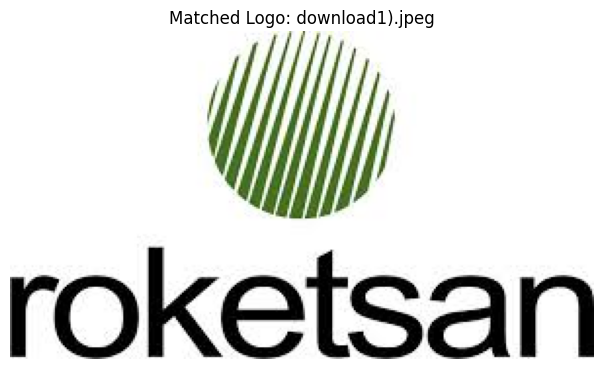

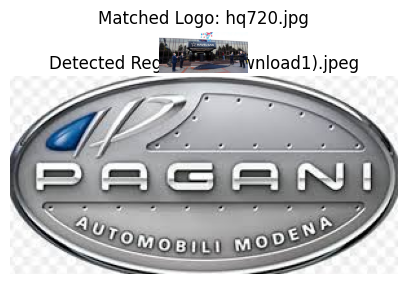

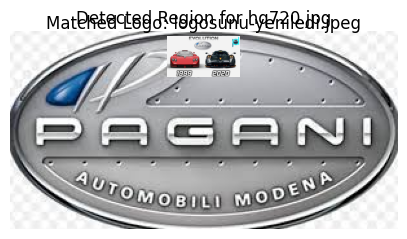

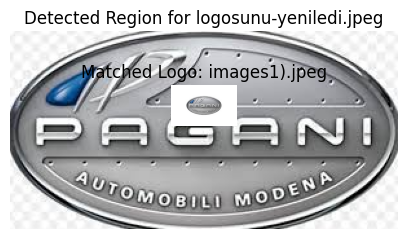

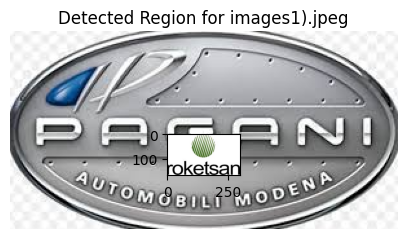

In [30]:
#with yolo

from ultralytics import YOLO
import cv2
import os
import numpy as np
from PIL import Image
import imagehash
from skimage.metrics import structural_similarity as ssim


# --- Library Imports ---
try:
    from PIL import Image
except ImportError:
    !pip install Pillow
try:
    import cv2
except ImportError:
    !pip install opencv-python

# --- Text Classification ---
classifier = pipeline("text-classification", model="dbmdz/bert-base-turkish-cased", return_all_scores=False)

# --- Data Loading ---
csv_file_path = '/content/sample_data/haber_veri_seti/dataset.csv'
df = pd.read_csv(csv_file_path, names=['Haber Adı', 'Haber'])

# --- Logo Directory ---
LOGO_DIR = '/content/sample_data/haber_veri_seti/logos/'




import matplotlib.pyplot as plt  # For displaying in Jupyter/Colab

def detect_logo(keyboard_image_path, logo_dir, visualize=True, save_path=None):
    """Detect logos in a keyboard image using YOLOv8 and match with logos in a folder using hashing and SSIM,
    with visualization of matched logos."""
    try:
        # Load the YOLOv8 model (pre-trained on COCO for general object detection)
        model = YOLO('yolov8n.pt')

        # Load and preprocess the keyboard image
        keyboard_img = cv2.imread(keyboard_image_path)
        if keyboard_img is None:
            print("Error: Could not load keyboard image.")
            return 0

        # Detect objects in the keyboard image (even lower confidence, no size filter)
        results = model(keyboard_img, conf=0.05)  # Very low confidence threshold for more detections
        detected_regions = []

        # Extract potential logo regions (no size or class filtering, just high-confidence regions)
        for result in results:
            boxes = result.boxes  # Bounding boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)  # Convert to integers
                conf = box.conf[0].cpu().numpy()  # Confidence score

                # Focus on any region with minimal confidence (no size filter)
                if conf > 0.05:  # Very low threshold to capture more regions
                    # Crop the region
                    roi = keyboard_img[y1:y2, x1:x2]
                    if roi.size > 0:  # Ensure the region is not empty
                        detected_regions.append((roi, (x1, y1, x2, y2)))  # Store region and coordinates

        if not detected_regions:
            print("No potential logo regions detected in the keyboard image.")
            return 0

        print(f"Detected {len(detected_regions)} potential logo regions.")

        # Preprocess images for comparison (with multi-scale and rotation handling)
        def preprocess_image(img, scales=[0.5, 1.0, 1.5, 2.0], angles=[0, 90, 180, 270]):
            best_gray = None
            best_similarity = -float('inf')
            height, width = img.shape[:2]

            for scale in scales:
                scaled_img = cv2.resize(img, (0, 0), fx=scale, fy=scale)
                for angle in angles:
                    # Rotate the image
                    if angle != 0:
                        center = (scaled_img.shape[1] // 2, scaled_img.shape[0] // 2)
                        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
                        rotated_img = cv2.warpAffine(scaled_img, rotation_matrix, (scaled_img.shape[1], scaled_img.shape[0]))
                    else:
                        rotated_img = scaled_img

                    # Convert to grayscale, blur, and enhance contrast
                    gray = cv2.cvtColor(rotated_img, cv2.COLOR_BGR2GRAY)
                    gray = cv2.resize(gray, (300, 300))  # Standard size for consistency
                    gray = cv2.GaussianBlur(gray, (5, 5), 0)  # Reduce noise
                    gray = cv2.equalizeHist(gray)  # Enhance contrast

                    # Use SSIM with a dummy reference to find the best version
                    if best_gray is None:
                        best_gray = gray
                        best_similarity = 0
                    else:
                        dummy_ssim = ssim(gray / 255.0, best_gray / 255.0, data_range=1.0)
                        if dummy_ssim > best_similarity:
                            best_gray = gray
                            best_similarity = dummy_ssim

            return best_gray

        # Load and preprocess logos from the folder
        logo_data = {}
        for logo_filename in os.listdir(logo_dir):
            if logo_filename.endswith(('.png', '.jpg', '.jpeg')):
                logo_path = os.path.join(logo_dir, logo_filename)
                try:
                    logo_img = cv2.imread(logo_path)
                    if logo_img is None:
                        print(f"Warning: Could not load {logo_path}.")
                        continue
                    preprocessed_logo = preprocess_image(logo_img)
                    # Use perceptual hashing and SSIM reference
                    logo_hash = imagehash.average_hash(Image.fromarray(preprocessed_logo))
                    logo_data[logo_filename] = {
                        'hash': logo_hash,
                        'image': preprocessed_logo,
                        'original': logo_img  # Store original for visualization
                    }
                except Exception as e:
                    print(f"Error processing {logo_path}: {e}")
                    continue

        if not logo_data:
            print("No logos processed successfully.")
            return 0

        # Compare detected regions with logos using hashing and SSIM
        matched_logos = set()  # Use a set to avoid counting the same logo multiple times
        max_hamming_distance = 40  # Keep this threshold
        ssim_threshold = 0.1  # Loosen this threshold further for Pagani logos

        matched_logos_data = []  # Store matched logos for visualization

        for region, coords in detected_regions:
            preprocessed_region = preprocess_image(region)
            region_hash = imagehash.average_hash(Image.fromarray(preprocessed_region))

            # Compare with each logo using both hashing and SSIM
            for logo_filename, logo_info in logo_data.items():
                logo_hash = logo_info['hash']
                logo_image = logo_info['image']

                # Check perceptual hash similarity
                hamming_distance = region_hash - logo_hash  # Hamming distance (difference in bits)
                print(f"{logo_filename}: Hamming distance = {hamming_distance}")

                # Check structural similarity (SSIM) with explicit data_range
                region_normalized = preprocessed_region / 255.0
                logo_normalized = logo_image / 255.0
                ssim_score = ssim(region_normalized, logo_normalized, data_range=1.0)

                print(f"{logo_filename}: SSIM score = {ssim_score:.4f}")

                # Consider a match if either metric meets its threshold
                if (hamming_distance <= max_hamming_distance and ssim_score >= ssim_threshold):
                    print(f"Keyboard logo matches {logo_filename} with Hamming={hamming_distance}/{max_hamming_distance} and SSIM={ssim_score:.4f}/{ssim_threshold}.")
                    matched_logos.add(logo_filename)
                    matched_logos_data.append((logo_info['original'], coords))  # Store original logo and region coords

        matched_logo_count = len(matched_logos)

        if matched_logo_count > 0:
            print(f"Keyboard logo matched with {matched_logo_count} logos in the folder.")
            print("Matched logos:", ", ".join(matched_logos))

            # Visualize or save matched logos
            if visualize:
                if save_path:
                    # Save matched logos as images
                    for i, (logo_img, region_coords) in enumerate(matched_logos_data):
                        # Save the logo
                        cv2.imwrite(os.path.join(save_path, f"matched_logo_{i}.jpg"), logo_img)
                        # Optionally, save a comparison with the detected region
                        region_img = keyboard_img[region_coords[1]:region_coords[3], region_coords[0]:region_coords[2]]
                        comparison = np.hstack((region_img, logo_img))
                        cv2.imwrite(os.path.join(save_path, f"comparison_logo_{i}.jpg"), comparison)
                    print(f"Matched logos saved to {save_path}")
                else:
                    # Display matched logos (for environments like Jupyter/Colab)
                    plt.figure(figsize=(10, 5 * len(matched_logos_data)))
                    for i, (logo_img, region_coords) in enumerate(matched_logos_data):
                        plt.subplot(len(matched_logos_data), 1, i + 1)
                        plt.imshow(cv2.cvtColor(logo_img, cv2.COLOR_BGR2RGB))
                        plt.title(f"Matched Logo: {list(matched_logos)[i]}")
                        plt.axis('off')
                        # Optionally show the detected region
                        region_img = keyboard_img[region_coords[1]:region_coords[3], region_coords[0]:region_coords[2]]
                        plt.figure(figsize=(5, 5))
                        plt.imshow(cv2.cvtColor(region_img, cv2.COLOR_BGR2RGB))
                        plt.title(f"Detected Region for {list(matched_logos)[i]}")
                        plt.axis('off')
                    plt.show()
            return matched_logo_count
        else:
            print("Keyboard logo did not match any logos in the folder sufficiently.")
            return 0

    except Exception as e:
        print(f"Error during logo detection: {e}")
        return 0
def classify_and_label(haber_baslik, haber_metni, target_company, keywords):
    """Classify news based on text analysis with robust keyword matching."""
    combined_text = f"{haber_baslik} {haber_metni}".upper()
    text_match = False
    if target_company.upper() in combined_text:
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword.upper()) + r'\b', combined_text):
                try:
                    result = classifier(haber_metni[:512])
                    if result[0]['label'] == "LABEL_1":
                        text_match = True
                        break
                except Exception as e:
                    print(f"Text classification error: {e}")
    return text_match

# --- Main Execution ---
sirket_adi = input("Lütfen şirket adını girin: ").strip().upper()
anahtar_kelime_input = input("Lütfen anahtar kelimeleri virgülle ayırarak girin: ")
anahtar_kelimeler = [kelime.strip().upper() for kelime in anahtar_kelime_input.split(',')]
keyboard_image_path = input("Lütfen klavyedeki (yüklenecek) logonun dosya yolunu girin: ")

# Logo analysis
num_logo_positive = detect_logo(keyboard_image_path, LOGO_DIR)

# Initialize counters
num_text_positive = 0
num_overall_positive = 0

# Analyze news
for index, row in df.iterrows():
    haber_baslik = str(row['Haber Adı'])
    haber_metni = str(row['Haber'])

    text_match = classify_and_label(haber_baslik, haber_metni, sirket_adi, anahtar_kelimeler)

    if text_match:
        num_text_positive += 1

# Calculate overall results
num_overall_positive = num_text_positive + num_logo_positive

# --- Print Results ---
print("\n--- Sonuçlar ---")
print(f"Toplam Haber Sayısı: {len(df)}")
print(f"Metin İçin İlgili Haber Sayısı ({sirket_adi} ve Anahtar Kelimeler): {num_text_positive}")
print(f"Logo İçin İlgili Haber Sayısı: {num_logo_positive}")
print(f"Toplam İlgili Haber Sayısı (Metin VEYA Logo): {num_overall_positive}")